# # RAMI Benchmarking 
 The goal of the RAMI4PILPS experiment[^1] is to evaluate different approaches by which Land Surface Models in larger Earth System Models quantify the radiation transfer within vegetation canopies. The RAMI4PILPS can be interpreted as a quality control mechanism used to: 

#1) quantify the errors in the radiative transfer scheme; 
#2) identify the impact that structural and spectral sub-grid variability may have on radiative transfer; and 
#3) verify the conservation of energy at the level of the surface, as well as inconsistencies arising from different levels of assumptions/simplifications. 

#This approach involves direct comparison with reference solutions obtained from highly accurate 3D models identified during the third phase of the RAMI benchmarking exercise[^2]. 

#A set of 3D experiments compares the partitioning of incident solar energy into an absorbed (A) flux, a transmitted (T) flux component and the surface reflectance (R). The overall canopy structure for these test cases is reminiscent of open forest canopies with randomly oriented foliage, confined to spherical volumes located at varying heights above the ground.
#In here, we use a total of 36 test cases including various canopy density, soil brightness, and illumination conditions for the visible (VIS) (400-700nm) and near infra-red (NIR) (700-3000nm) spectral ranges. 

 [^1]: J.L. Widlowski, B. Pinty, M. Clerici, Y. Dai, M. De Kauwe, K. de Ridder, A. Kallel, H. Kobayashi, T. Lavergne, W. Ni-Meister, A. Olchev, T. Quaife, S. Wang, W. Yang, Y. Yang, and H. Yuan (2011), RAMI4PILPS: An intercomparison of formulations for the partitioning of solar radiation in land surface models, Journal of Geophysical Research, 116, G02019, 25, DOI: 10.1029/2010JG001511.
 
 [^2]: Widlowski, J-L., M. Taberner, B. Pinty, V. Bruniquel-Pinel, M. Disney, R. Fernandes, J.-P. Gastellu-Etchegorry, N. Gobron, A. Kuusk, T. Lavergne, S. Leblanc, P. Lewis, E. Martin, M. Mottus, P. J. R. North, W. Qin, M.Robustelli, N. Rochdi, R.Ruiloba, C.Soler, R.Thompson, W. Verhoef, M. M.Verstraete, and D. Xie (2007), 'The third RAdiation transfer Model Intercomparison (RAMI) exercise: Documenting progress in canopy reflectance modelling', Journal of Geophysical Research, 112, D09111, 28, DOI: 10.1029/2006JD007821. 


In [ ]:

## Use Julia Plots package and switch to plotly js option:
using Plots
pyplot()

#----------------------------------------------------------------------------

# First, we include Revise (good for debugging) and Parameters (tools for structures)

#using Revise
using Parameters
#----------------------------------------------------------------------------

# Now include the Land modules

using Land
using Land.CanopyRT
#----------------------------------------------------------------------------

In [2]:
#Defining all reference values for the Sparse case 


RAMI_SZA = [27.,60.,83.]

RAMI_fabsRed_050_BLK =  [0.09380509999999999, 0.16259713, 0.53931207]
RAMI_frefRed_050_BLK =  [0.00330673, 0.00517598, 0.01626682]
RAMI_ftranRed_050_BLK =  [0.90288817, 0.83222689, 0.44442110999999995]

RAMI_fabsRed_050_MED =  [0.10897124, 0.17760124000000002, 0.54764719]
RAMI_frefRed_050_MED =  [0.09759354, 0.09107608, 0.06177913]
RAMI_ftranRed_050_MED =  [0.90337609, 0.83265704, 0.44469279]

RAMI_fabsRed_050_SNW =  [0.21471034, 0.28200132, 0.60564705]
RAMI_frefRed_050_SNW =  [0.7526521700000001, 0.6879087300000001, 0.37825442000000004]
RAMI_ftranRed_050_SNW =  [0.90659694, 0.83583194, 0.44718138]


3-element Array{Float64,1}:
 0.90659694
 0.83583194
 0.44718138

In [3]:
arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRT.canopy.nlayers)
for i = 1:CanopyRT.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    CanopyRT.fluspect!(arrayOfLeaves[i], CanopyRT.optis)
end

In [4]:
#### Default Black soil albedo Case

#Soil albedo
#BLK
CanopyRT.soil.albedo_SW[:] .=0.0;

reflRed_SZA = []
absRed_SZA = []
transRed_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=0.50265


for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
    #Setting all diffuse to zero
    sunRad.E_diffuse[28] = 0.0
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end

#### Clumped Case

reflRed_clump_SZA = []
absRed_clump_SZA = []
transRed_clump_SZA = []


#Sparse
CanopyRT.canopy.Ω = 0.365864235

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_clump_SZA, canRad.alb_direct[28])
    push!(absRed_clump_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_clump_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end


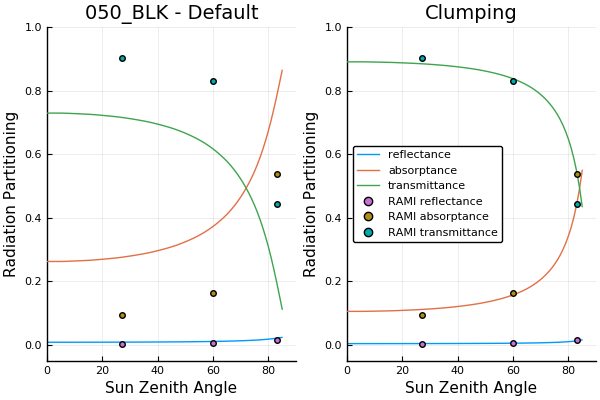

In [5]:
SZA=0:1:85

plot(SZA, [reflRed_SZA, reflRed_clump_SZA],label=["" "reflectance"] , layout = (1, 2),title=["050_BLK - Default" "Clumping"])
plot!(SZA, [absRed_SZA, absRed_clump_SZA] ,label=["" "absorptance"])
plot!(SZA, [transRed_SZA,transRed_clump_SZA],label=["" "transmittance"])


##Reference values
scatter!(RAMI_SZA, [RAMI_frefRed_050_BLK,RAMI_frefRed_050_BLK],label=["" "RAMI reflectance"])
scatter!(RAMI_SZA, [RAMI_fabsRed_050_BLK,RAMI_fabsRed_050_BLK],label=["" "RAMI absorptance"])
scatter!(RAMI_SZA, [RAMI_ftranRed_050_BLK,RAMI_ftranRed_050_BLK],label=["" "RAMI transmittance"])
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")

plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)



In [6]:
#### Default Medium Soil albedo Case

#Soil albedo
#MED
CanopyRT.soil.albedo_SW[:] .=0.1217;

reflRed_SZA = []
absRed_SZA = []
transRed_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=0.50265


for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
    #Setting all diffuse to zero
    sunRad.E_diffuse[28] = 0.0
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end

#### Clumped Case

reflRed_clump_SZA = []
absRed_clump_SZA = []
transRed_clump_SZA = []


#Sparse
CanopyRT.canopy.Ω = 0.365864235

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_clump_SZA, canRad.alb_direct[28])
    push!(absRed_clump_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_clump_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end


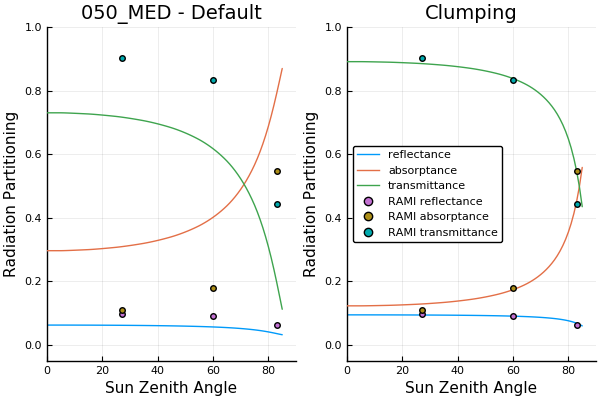

In [7]:
SZA=0:1:85

plot(SZA, [reflRed_SZA, reflRed_clump_SZA],label=["" "reflectance"] , layout = (1, 2),title=["050_MED - Default" "Clumping"])
plot!(SZA, [absRed_SZA, absRed_clump_SZA] ,label=["" "absorptance"])
plot!(SZA, [transRed_SZA,transRed_clump_SZA],label=["" "transmittance"])


##Reference values
scatter!(RAMI_SZA, [RAMI_frefRed_050_MED,RAMI_frefRed_050_MED],label=["" "RAMI reflectance"])
scatter!(RAMI_SZA, [RAMI_fabsRed_050_MED,RAMI_fabsRed_050_MED],label=["" "RAMI absorptance"])
scatter!(RAMI_SZA, [RAMI_ftranRed_050_MED,RAMI_ftranRed_050_MED],label=["" "RAMI transmittance"])
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")

plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)


In [8]:
#### Default Snowy Soil albedo Case

#Soil albedo
#SNW
CanopyRT.soil.albedo_SW[:] .=0.9640;

reflRed_SZA = []
absRed_SZA = []
transRed_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=0.50265


for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
    #Setting all diffuse to zero
    sunRad.E_diffuse[28] = 0.0
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end

#### Clumped Case

reflRed_clump_SZA = []
absRed_clump_SZA = []
transRed_clump_SZA = []


#Sparse
CanopyRT.canopy.Ω = 0.365864235

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_clump_SZA, canRad.alb_direct[28])
    push!(absRed_clump_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_clump_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end


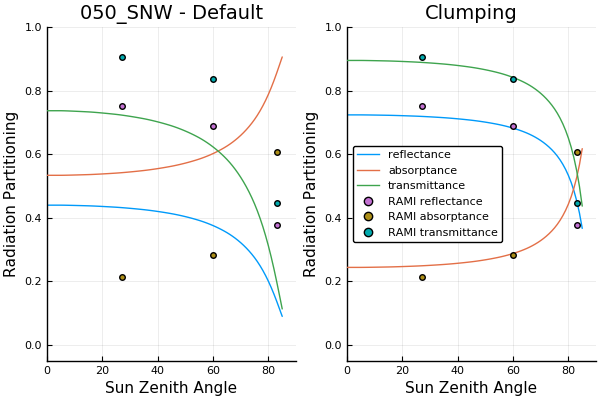

In [9]:
SZA=0:1:85

plot(SZA, [reflRed_SZA, reflRed_clump_SZA],label=["" "reflectance"] , layout = (1, 2),title=["050_SNW - Default" "Clumping"])
plot!(SZA, [absRed_SZA, absRed_clump_SZA] ,label=["" "absorptance"])
plot!(SZA, [transRed_SZA,transRed_clump_SZA],label=["" "transmittance"])


##Reference values
scatter!(RAMI_SZA, [RAMI_frefRed_050_SNW,RAMI_frefRed_050_SNW],label=["" "RAMI reflectance"])
scatter!(RAMI_SZA, [RAMI_fabsRed_050_SNW,RAMI_fabsRed_050_SNW],label=["" "RAMI absorptance"])
scatter!(RAMI_SZA, [RAMI_ftranRed_050_SNW,RAMI_ftranRed_050_SNW],label=["" "RAMI transmittance"])
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")

plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)

In [10]:
#Defining all reference values for the Medium case 

RAMI_SZA = [27.,60.,83.]


RAMI_fabsRed_150_BLK =  [0.28137804, 0.46514268999999997, 0.89063486]
RAMI_frefRed_150_BLK =  [0.00923676, 0.01379672, 0.02970703]
RAMI_ftranRed_150_BLK =  [0.7093851999999999, 0.52106059, 0.07965811]

RAMI_fabsRed_150_MED =  [0.31403827, 0.49003033, 0.89432051]
RAMI_frefRed_150_MED =  [0.06195053, 0.05151941, 0.03561715]
RAMI_ftranRed_150_MED =  [0.7104761399999999, 0.52197456, 0.07977039000000001]

RAMI_fabsRed_150_SNW =  [0.5431621799999999, 0.66519762, 0.9201217300000001]
RAMI_frefRed_150_SNW =  [0.43100610000000006, 0.31581022999999997, 0.07698033]
RAMI_ftranRed_150_SNW =  [0.71754777, 0.52755972, 0.08049832999999999]

3-element Array{Float64,1}:
 0.71754777         
 0.52755972         
 0.08049832999999999

In [11]:
#### Default Black soil albedo Case

#Soil albedo
#BLK
CanopyRT.soil.albedo_SW[:] .=0.0;

reflRed_SZA = []
absRed_SZA = []
transRed_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=1.5017


for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
    #Setting all diffuse to zero
    sunRad.E_diffuse[28] = 0.0
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end

#### Clumped Case

reflRed_clump_SZA = []
absRed_clump_SZA = []
transRed_clump_SZA = []


#Medium
CanopyRT.canopy.Ω = 0.405417644

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_clump_SZA, canRad.alb_direct[28])
    push!(absRed_clump_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_clump_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end


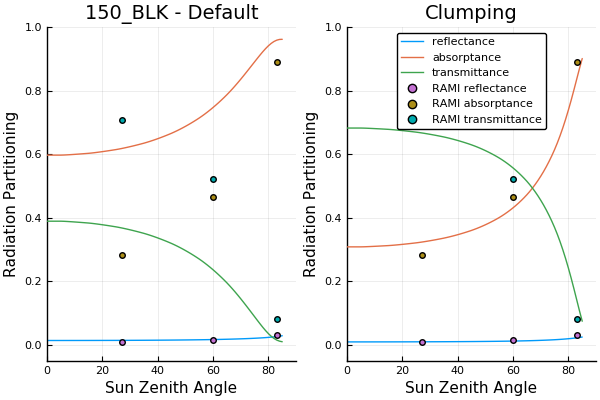

In [12]:
SZA=0:1:85

plot(SZA, [reflRed_SZA, reflRed_clump_SZA],label=["" "reflectance"] , layout = (1, 2),title=["150_BLK - Default" "Clumping"])
plot!(SZA, [absRed_SZA, absRed_clump_SZA] ,label=["" "absorptance"])
plot!(SZA, [transRed_SZA,transRed_clump_SZA],label=["" "transmittance"])


##Reference values
scatter!(RAMI_SZA, [RAMI_frefRed_150_BLK,RAMI_frefRed_150_BLK],label=["" "RAMI reflectance"])
scatter!(RAMI_SZA, [RAMI_fabsRed_150_BLK,RAMI_fabsRed_150_BLK],label=["" "RAMI absorptance"])
scatter!(RAMI_SZA, [RAMI_ftranRed_150_BLK,RAMI_ftranRed_150_BLK],label=["" "RAMI transmittance"])
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")

plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)


In [13]:
#### Default Medium soil albedo Case

#Soil albedo
#MED
CanopyRT.soil.albedo_SW[:] .=0.1217;

reflRed_SZA = []
absRed_SZA = []
transRed_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=1.5017


for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
    #Setting all diffuse to zero
    sunRad.E_diffuse[28] = 0.0
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end

#### Clumped Case

reflRed_clump_SZA = []
absRed_clump_SZA = []
transRed_clump_SZA = []


#Medium
CanopyRT.canopy.Ω = 0.405417644

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_clump_SZA, canRad.alb_direct[28])
    push!(absRed_clump_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_clump_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end


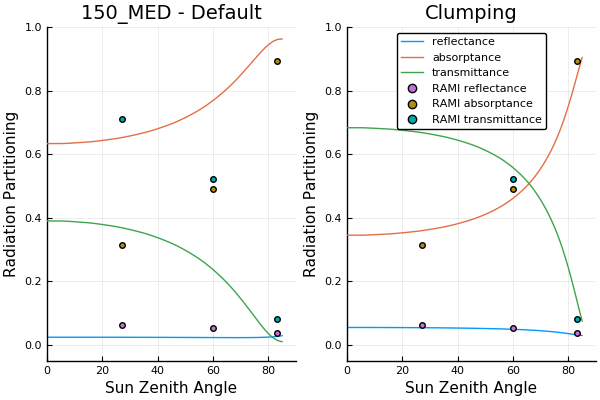

In [14]:
SZA=0:1:85

plot(SZA, [reflRed_SZA, reflRed_clump_SZA],label=["" "reflectance"] , layout = (1, 2),title=["150_MED - Default" "Clumping"])
plot!(SZA, [absRed_SZA, absRed_clump_SZA] ,label=["" "absorptance"])
plot!(SZA, [transRed_SZA,transRed_clump_SZA],label=["" "transmittance"])


##Reference values
scatter!(RAMI_SZA, [RAMI_frefRed_150_MED,RAMI_frefRed_150_MED],label=["" "RAMI reflectance"])
scatter!(RAMI_SZA, [RAMI_fabsRed_150_MED,RAMI_fabsRed_150_MED],label=["" "RAMI absorptance"])
scatter!(RAMI_SZA, [RAMI_ftranRed_150_MED,RAMI_ftranRed_150_MED],label=["" "RAMI transmittance"])
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")

plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)


In [15]:
#### Default Snowy soil albedo Case

#Soil albedo
#SNW
CanopyRT.soil.albedo_SW[:] .=0.9640;

reflRed_SZA = []
absRed_SZA = []
transRed_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=1.5017


for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
    #Setting all diffuse to zero
    sunRad.E_diffuse[28] = 0.0
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end

#### Clumped Case

reflRed_clump_SZA = []
absRed_clump_SZA = []
transRed_clump_SZA = []


#Medium
CanopyRT.canopy.Ω = 0.405417644

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_clump_SZA, canRad.alb_direct[28])
    push!(absRed_clump_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_clump_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end


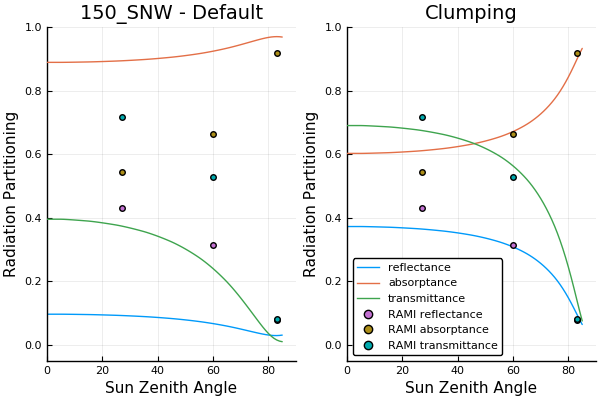

In [16]:
SZA=0:1:85

plot(SZA, [reflRed_SZA, reflRed_clump_SZA],label=["" "reflectance"] , layout = (1, 2),title=["150_SNW - Default" "Clumping"])
plot!(SZA, [absRed_SZA, absRed_clump_SZA] ,label=["" "absorptance"])
plot!(SZA, [transRed_SZA,transRed_clump_SZA],label=["" "transmittance"])


##Reference values
scatter!(RAMI_SZA, [RAMI_frefRed_150_SNW,RAMI_frefRed_150_SNW],label=["" "RAMI reflectance"])
scatter!(RAMI_SZA, [RAMI_fabsRed_150_SNW,RAMI_fabsRed_150_SNW],label=["" "RAMI absorptance"])
scatter!(RAMI_SZA, [RAMI_ftranRed_150_SNW,RAMI_ftranRed_150_SNW],label=["" "RAMI transmittance"])
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")

plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)


In [17]:
#Defining all reference values for the Dense case 

RAMI_SZA = [27.,60.,83.]


RAMI_fabsRed_250_BLK =  [0.46852539, 0.70426097, 0.9461774300000001]
RAMI_frefRed_250_BLK =  [0.01445858, 0.02016963, 0.03477486]
RAMI_ftranRed_250_BLK =  [0.51701603, 0.2755694, 0.01904771]

RAMI_fabsRed_250_MED =  [0.50540545, 0.72429659, 0.94742381]
RAMI_frefRed_250_MED =  [0.03953053, 0.03315039, 0.03580858]
RAMI_ftranRed_250_MED =  [0.51811911, 0.27616192, 0.01909098]

RAMI_fabsRed_250_SNW =  [0.76512258, 0.86538802, 0.9562473199999999]
RAMI_frefRed_250_SNW =  [0.21595537, 0.124503, 0.043056080000000004]
RAMI_ftranRed_250_SNW =  [0.5256125, 0.280805, 0.01935]

3-element Array{Float64,1}:
 0.5256125
 0.280805 
 0.01935  

In [18]:
#### Default Black soil albedo Case

#Soil albedo
#BLK
CanopyRT.soil.albedo_SW[:] .=0.0000;

reflRed_SZA = []
absRed_SZA = []
transRed_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=2.5007


for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
    #Setting all diffuse to zero
    sunRad.E_diffuse[28] = 0.0
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end

#### Clumped Case

reflRed_clump_SZA = []
absRed_clump_SZA = []
transRed_clump_SZA = []


#Dense
CanopyRT.canopy.Ω = 0.45946608

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_clump_SZA, canRad.alb_direct[28])
    push!(absRed_clump_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_clump_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end


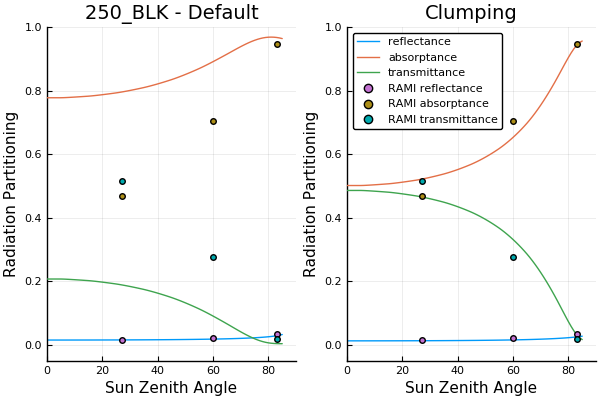

In [19]:
SZA=0:1:85

plot(SZA, [reflRed_SZA, reflRed_clump_SZA],label=["" "reflectance"] , layout = (1, 2),title=["250_BLK - Default" "Clumping"])
plot!(SZA, [absRed_SZA, absRed_clump_SZA] ,label=["" "absorptance"])
plot!(SZA, [transRed_SZA,transRed_clump_SZA],label=["" "transmittance"])


##Reference values
scatter!(RAMI_SZA, [RAMI_frefRed_250_BLK,RAMI_frefRed_250_BLK],label=["" "RAMI reflectance"])
scatter!(RAMI_SZA, [RAMI_fabsRed_250_BLK,RAMI_fabsRed_250_BLK],label=["" "RAMI absorptance"])
scatter!(RAMI_SZA, [RAMI_ftranRed_250_BLK,RAMI_ftranRed_250_BLK],label=["" "RAMI transmittance"])
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")

plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)


In [20]:
#### Default Medium soil albedo Case

#Soil albedo
#MED
CanopyRT.soil.albedo_SW[:] .=0.1217;

reflRed_SZA = []
absRed_SZA = []
transRed_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=2.5007


for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
    #Setting all diffuse to zero
    sunRad.E_diffuse[28] = 0.0
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end

#### Clumped Case

reflRed_clump_SZA = []
absRed_clump_SZA = []
transRed_clump_SZA = []


#Dense
CanopyRT.canopy.Ω = 0.45946608

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_clump_SZA, canRad.alb_direct[28])
    push!(absRed_clump_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_clump_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end


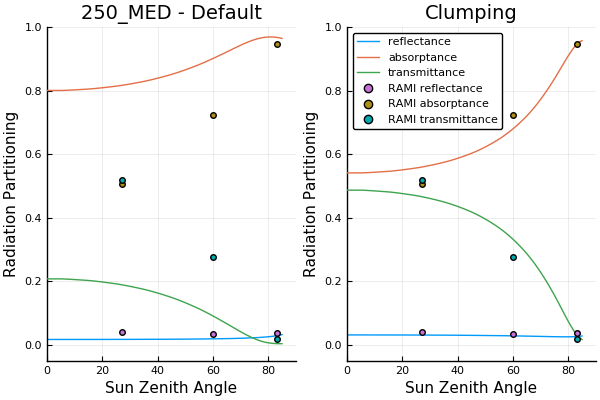

In [21]:
SZA=0:1:85

plot(SZA, [reflRed_SZA, reflRed_clump_SZA],label=["" "reflectance"] , layout = (1, 2),title=["250_MED - Default" "Clumping"])
plot!(SZA, [absRed_SZA, absRed_clump_SZA] ,label=["" "absorptance"])
plot!(SZA, [transRed_SZA,transRed_clump_SZA],label=["" "transmittance"])


##Reference values
scatter!(RAMI_SZA, [RAMI_frefRed_250_MED,RAMI_frefRed_250_MED],label=["" "RAMI reflectance"])
scatter!(RAMI_SZA, [RAMI_fabsRed_250_MED,RAMI_fabsRed_250_MED],label=["" "RAMI absorptance"])
scatter!(RAMI_SZA, [RAMI_ftranRed_250_MED,RAMI_ftranRed_250_MED],label=["" "RAMI transmittance"])
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")

plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)


In [22]:
#### Default  Snowy soil albedo Case

#Soil albedo
#SNW
CanopyRT.soil.albedo_SW[:] .=0.9640;

reflRed_SZA = []
absRed_SZA = []
transRed_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=2.5007


for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
    #Setting all diffuse to zero
    sunRad.E_diffuse[28] = 0.0
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end

#### Clumped Case

reflRed_clump_SZA = []
absRed_clump_SZA = []
transRed_clump_SZA = []


#Dense
CanopyRT.canopy.Ω = 0.45946608

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_clump_SZA, canRad.alb_direct[28])
    push!(absRed_clump_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_clump_SZA,  (canOpt.Es_[28,end] .+ canRad.E_down[28,end])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))

end


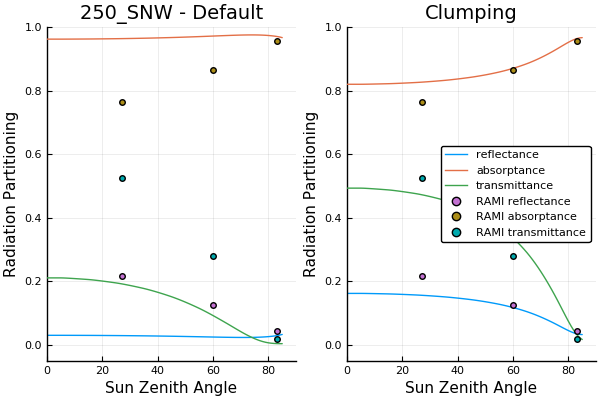

In [23]:
SZA=0:1:85

plot(SZA, [reflRed_SZA, reflRed_clump_SZA],label=["" "reflectance"] , layout = (1, 2),title=["250_SNW - Default" "Clumping"])
plot!(SZA, [absRed_SZA, absRed_clump_SZA] ,label=["" "absorptance"])
plot!(SZA, [transRed_SZA,transRed_clump_SZA],label=["" "transmittance"])


##Reference values
scatter!(RAMI_SZA, [RAMI_frefRed_250_SNW,RAMI_frefRed_250_SNW],label=["" "RAMI reflectance"])
scatter!(RAMI_SZA, [RAMI_fabsRed_250_SNW,RAMI_fabsRed_250_SNW],label=["" "RAMI absorptance"])
scatter!(RAMI_SZA, [RAMI_ftranRed_250_SNW,RAMI_ftranRed_250_SNW],label=["" "RAMI transmittance"])
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")

plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)


# ### Test a VZA dependence in the principal plane with clumping

In [24]:
# Define a few wavelengths:
wl_blue = 450.0;
wl_red = 600.0;
wl_FarRed = 740.0;
wl_Red = 685.0;
ind_wle_blue  = argmin(abs.(wle .-wl_blue));
ind_wle_red = argmin(abs.(wle .-wl_red));
ind_wlf_FR  = argmin(abs.(wlf .-wl_FarRed));
ind_wlf_R  = argmin(abs.(wlf .-wl_Red));
ind_red = argmin(abs.(wl .-wl_Red));
ind_NIR = argmin(abs.(wl .-800));

# This is to be changed later but at the moment, we need to generate an Array of leaves, basically for each layer of the canopy
arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRT.canopy.nlayers)
for i = 1:CanopyRT.canopy.nlayers
    ##@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    CanopyRT.fluspect!(arrayOfLeaves[i], CanopyRT.optis)
end


In [25]:
SIF_FR = Float32[]
SIF_R = Float32[]
reflVIS = Float32[]
reflNIR = Float32[]

## Just running the code over all geometries:
#MED
CanopyRT.soil.albedo_SW[:] .=0.1217;
## Set sun SZA to 27 degrees
CanopyRT.angles.tts=27.
## Set 0 azimuth (principal plane)
CanopyRT.angles.psi=0

#Adding clumping 
CanopyRT.canopy.Ω = 1.0
## LAI of 3:
CanopyRT.canopy.LAI = 2.5007
## Define VZA 
VZA=collect(-89.5:0.5:89.5)

for VZA_ in VZA
    CanopyRT.angles.tto=VZA_
    CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    CanopyRT.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRT.soil);
    ## Handpicked indices in 
    push!(reflVIS, canRad.alb_obs[ind_red])
    push!(reflNIR, canRad.alb_obs[ind_NIR])
    push!(SIF_R , canRad.SIF_obs[ind_wlf_R])
    push!(SIF_FR, canRad.SIF_obs[ind_wlf_FR ])
end


#Adding clumping 
CanopyRT.canopy.Ω = 0.45946608

SIF_FR_clump = Float32[]
SIF_R_clump = Float32[]
reflVIS_clump = Float32[]
reflNIR_clump = Float32[]


for VZA_ in VZA
    CanopyRT.angles.tto=VZA_
    CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    CanopyRT.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRT.soil);
    ## Handpicked indices in 
    push!(reflVIS_clump, canRad.alb_obs[ind_red])
    push!(reflNIR_clump, canRad.alb_obs[ind_NIR])
    push!(SIF_R_clump , canRad.SIF_obs[ind_wlf_R])
    push!(SIF_FR_clump, canRad.SIF_obs[ind_wlf_FR ])
end

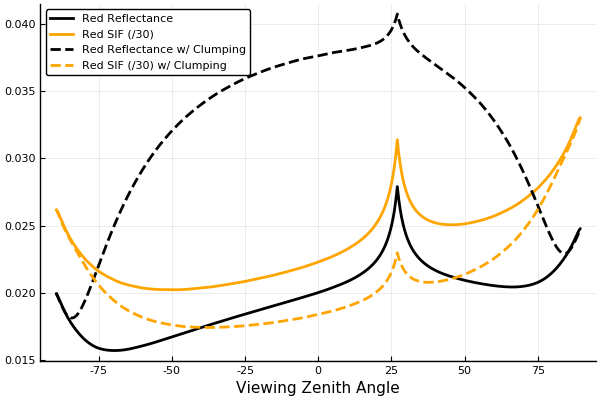

In [26]:
## Plots Visible 
plot(VZA, reflVIS, color=[:black],label="Red Reflectance", lw=2)
plot!(VZA, SIF_R/30, color=[:orange],label="Red SIF (/30)", lw=2)
plot!(VZA, reflVIS_clump, color=[:black], line=(:dash,2),label="Red Reflectance w/ Clumping", lw=2)
plot!(VZA, SIF_R_clump/30, color=[:orange], line=(:dash,2),label="Red SIF (/30) w/ Clumping", lw=2)
xlabel!("Viewing Zenith Angle")
#----------------------------------------------------------------------------

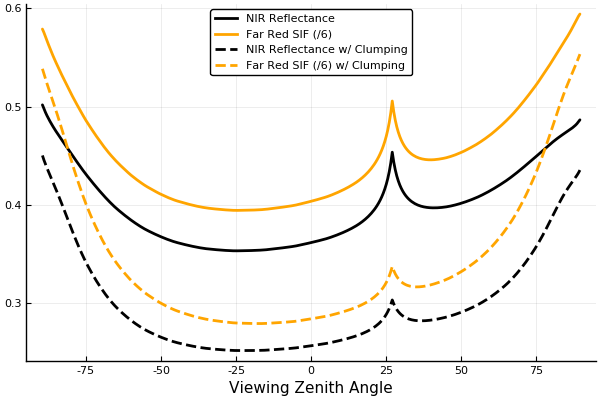

In [27]:
## Plots Visible 
plot(VZA, reflNIR, color=[:black],label="NIR Reflectance", lw=2)
plot!(VZA, SIF_FR/6, color=[:orange],label="Far Red SIF (/6)", lw=2)
plot!(VZA, reflNIR_clump, color=[:black], line=(:dash,2),label="NIR Reflectance w/ Clumping", lw=2)
plot!(VZA, SIF_FR_clump/6, color=[:orange], line=(:dash,2),label="Far Red SIF (/6) w/ Clumping", lw=2)
xlabel!("Viewing Zenith Angle")
#----------------------------------------------------------------------------

# ## BRDF sampling

By going through viewing and azimuth angles, we can construct a full BRDF for reflectance and SIF emissions at different wavelengths:


In [28]:
reflVIS = Float32[]
reflNIR = Float32[]
SIF_FR = Float32[]
SIF_R  = Float32[]

#MED
CanopyRT.soil.albedo_SW[:] .=0.1217;
CanopyRT.angles.tts=27.
CanopyRT.angles.psi=0
CanopyRT.canopy.LAI=2.5007
CanopyRT.canopy.Ω = 1.0
for psi=0:360
    CanopyRT.angles.psi=psi
    for VZA=0:1:85
        CanopyRT.angles.tto=VZA

        CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt);
        CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
        CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
        CanopyRT.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRT.soil);
        push!(reflVIS, canRad.alb_obs[28])
        push!(reflNIR, canRad.alb_obs[52])
        push!(SIF_R , canRad.SIF_obs[8])
        push!(SIF_FR, canRad.SIF_obs[20])
    end
end

#Adding clumping 
CanopyRT.canopy.Ω = 0.45946608

SIF_FR_clump = Float32[]
SIF_R_clump = Float32[]
reflVIS_clump = Float32[]
reflNIR_clump = Float32[]

for psi=0:360
    CanopyRT.angles.psi=psi
    for VZA=0:1:85
        CanopyRT.angles.tto=VZA

        CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt);
        CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);
        CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
        CanopyRT.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRT.soil);
        push!(reflVIS_clump, canRad.alb_obs[28])
        push!(reflNIR_clump, canRad.alb_obs[52])
        push!(SIF_R_clump , canRad.SIF_obs[8])
        push!(SIF_FR_clump, canRad.SIF_obs[20])
    end
end



In [29]:
A = reshape(reflNIR, ( 86,361));
B = reshape(reflVIS, ( 86,361));
SIFFER = reshape(SIF_R, ( 86,361));
SIFFER_FR = reshape(SIF_FR, ( 86,361));

A_clump = reshape(reflNIR_clump, ( 86,361));
B_clump = reshape(reflVIS_clump, ( 86,361));
SIFFER_clump = reshape(SIF_R_clump, ( 86,361));
SIFFER_FR_clump = reshape(SIF_FR_clump, ( 86,361));

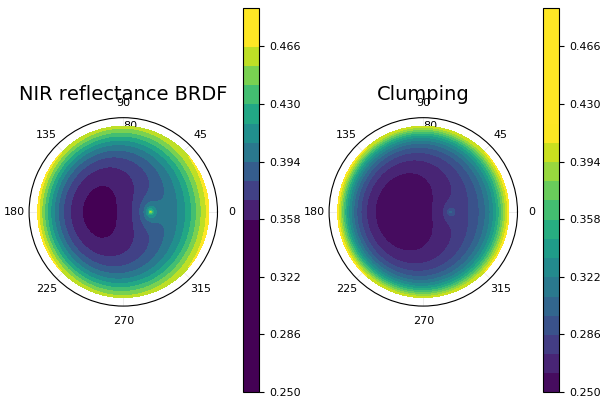

In [30]:

hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  [A,A_clump],  proj=:polar, color=:viridis, alpha=0.5,levels=collect(0.25:0.012:0.5),layout = (1, 2),title=["NIR reflectance BRDF" "Clumping"])


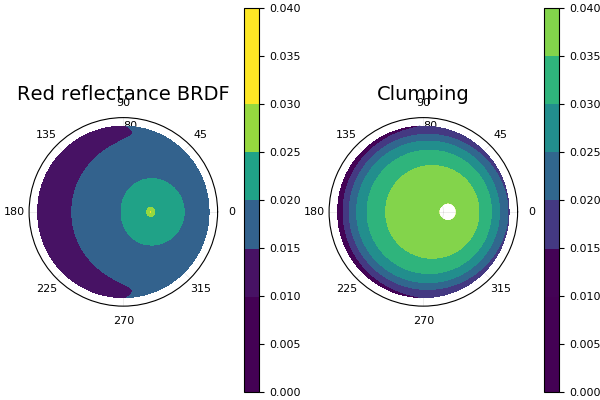

In [31]:
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  [B,B_clump],  proj=:polar, color=:viridis, alpha=0.5,levels=collect(0.0:0.005:0.04),layout = (1, 2),title=["Red reflectance BRDF" "Clumping"])


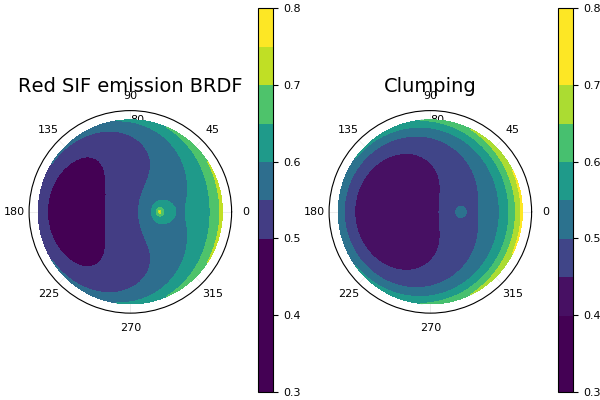

In [36]:
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  [SIFFER,SIFFER_clump],  proj=:polar, color=:viridis, alpha=0.5,levels=collect(0.3:0.05:0.8),layout = (1, 2),title=["Red SIF emission BRDF" "Clumping"])


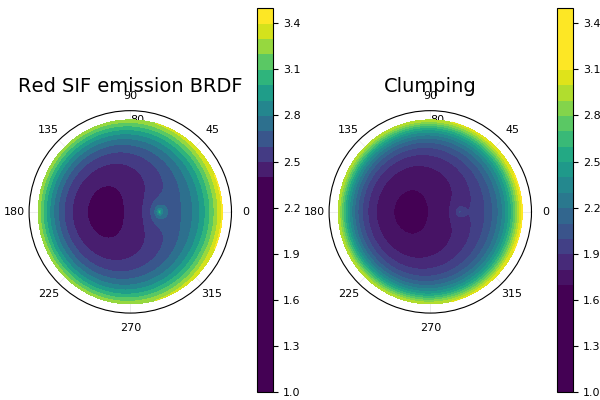

In [48]:
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  [SIFFER_FR,SIFFER_FR_clump],  proj=:polar, color=:viridis, alpha=0.5,levels=collect(1.:0.1:3.5),layout = (1, 2),title=["Red SIF emission BRDF" "Clumping"])
